In [1]:
# %load tests/test_nets.py

import sys
sys.path.append('python/')

import netvlad_tf.nets as nets

import cv2
import numpy as np
import scipy.io as scio
import tensorflow as tf
import time
import unittest

import netvlad_tf.net_from_mat as nfm

class TestNets(unittest.TestCase):
    def testVgg16NetvladPca(self):
        ''' Need example_stats.mat in matlab folder, which can be generated
        with get_example_stats.m. Also need translated checkpoint, can be
        generated with mat_to_checkpoint.py. '''
        tf.reset_default_graph()

        image_batch = tf.placeholder(
                dtype=tf.float32, shape=[None, None, None, 3])

        net_out = nets.vgg16NetvladPca(image_batch)
        saver = tf.train.Saver()

        sess = tf.Session()
        saver.restore(sess, nets.defaultCheckpoint())

        inim = cv2.imread(nfm.exampleImgPath())
        inim = cv2.cvtColor(inim, cv2.COLOR_BGR2RGB)

        batch = np.expand_dims(inim, axis=0)

        #%% Generate TF results
        for _ in range(2):
            sess.run(net_out, feed_dict={image_batch: batch})
        t = time.time()
        result = sess.run(net_out, feed_dict={image_batch: batch})
        print('Took %f seconds' % (time.time() - t))

        #%% Load Matlab results
        mat = scio.loadmat(nfm.exampleStatPath(),
                           struct_as_record=False, squeeze_me=True)
        mat_outs = mat['outs']

        #%% Compare final output
        out_diff = np.abs(mat_outs[-1] - result)
        self.assertLess(np.linalg.norm(out_diff), 0.0053)
        print('Error of final vector is %f' % np.linalg.norm(out_diff))
        
        sess.close() # release GPU, etc

In [2]:
test = TestNets()
test.testVgg16NetvladPca()

Instructions for updating:
dim is deprecated, use axis instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:Restoring parameters from checkpoints/vd16_pitts30k_conv5_3_vlad_preL2_intra_white
Took 0.524710 seconds
Error of final vector is 0.005228


In [1]:
import cv2
import numpy as np
import sys

import tensorflow as tf

sys.path.append('python/')
import netvlad_tf.net_from_mat as nfm
import netvlad_tf.nets as nets

In [2]:
tf.reset_default_graph()

image_batch = tf.placeholder(
        dtype=tf.float32, shape=[None, None, None, 3])

net_out = nets.vgg16NetvladPca(image_batch)
saver = tf.train.Saver()

sess = tf.Session()
saver.restore(sess, nets.defaultCheckpoint())

inim = cv2.imread(nfm.exampleImgPath())
inim = cv2.cvtColor(inim, cv2.COLOR_BGR2RGB)

batch = np.expand_dims(inim, axis=0)
result = sess.run(net_out, feed_dict={image_batch: batch})

sess.close()

Instructions for updating:
dim is deprecated, use axis instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:Restoring parameters from checkpoints/vd16_pitts30k_conv5_3_vlad_preL2_intra_white


In [6]:
result

array([[-0.00681989, -0.00276461, -0.00730953, ...,  0.01022781,
        -0.00939505, -0.00270358]], dtype=float32)

In [9]:
result.shape

(1, 4096)

In [22]:
# if you fancy listing all layers (remember not to call sess.close())
for op in sess.graph.get_operations():
        # print(op.name)
        print(op.values())

In [1]:
import sys
sys.path.append('python/')
import netvlad_tf.nets as nets

import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio
import scipy.spatial.distance as scid
import scipy.signal as scisig
import tensorflow as tf
import time

from netvlad_tf.image_descriptor import ImageDescriptor
import netvlad_tf.net_from_mat as nfm
import netvlad_tf.precision_recall as pr

In [2]:
use_dim = 128

tf.reset_default_graph()
try:
    imd.sess.close()
except:
    pass
imd = ImageDescriptor(is_grayscale=False)

# It's faster passing a batch to tf instead of individual images, but my gpu has only 2GB... 
feats = []
for i in range(5):
    img = cv2.imread('example'+str(i)+'.jpg') #, cv2.IMREAD_GRAYSCALE)
    new_image_size = (img.shape[0] - (img.shape[0] % 32),
                      img.shape[1] - (img.shape[1] % 32))
    img = cv2.resize(img,(int(new_image_size[1]/4), int(new_image_size[0]/4)))
    feats = feats + list(imd.describeImage(img))

use_feats = np.array(feats)[:, :use_dim]

Instructions for updating:
dim is deprecated, use axis instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:Restoring parameters from checkpoints/vd16_pitts30k_conv5_3_vlad_preL2_intra_white


In [13]:
#%% Suppressing a certain radius around the diagonal to prevent self-matches
# (not real loop closures).
suppression_diameter = 0
diag_suppression = scisig.convolve2d(
        np.eye(use_feats.shape[0]), np.ones((1, suppression_diameter)), 'same')

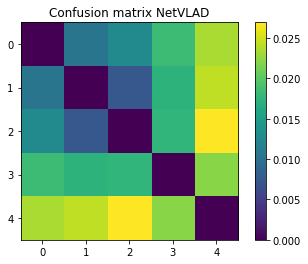

In [14]:
#%% NetVLAD matching, reject along diagonal (query ~ match):
sq_dists = scid.squareform(scid.pdist(use_feats, 'sqeuclidean'))
sq_dists[diag_suppression > 0] = np.inf
plt.imshow(sq_dists)
plt.title('Confusion matrix NetVLAD')
plt.colorbar()
plt.show()

nv_dists2 = sq_dists.min(axis=0)
nv_indices = sq_dists.argmin(axis=0)

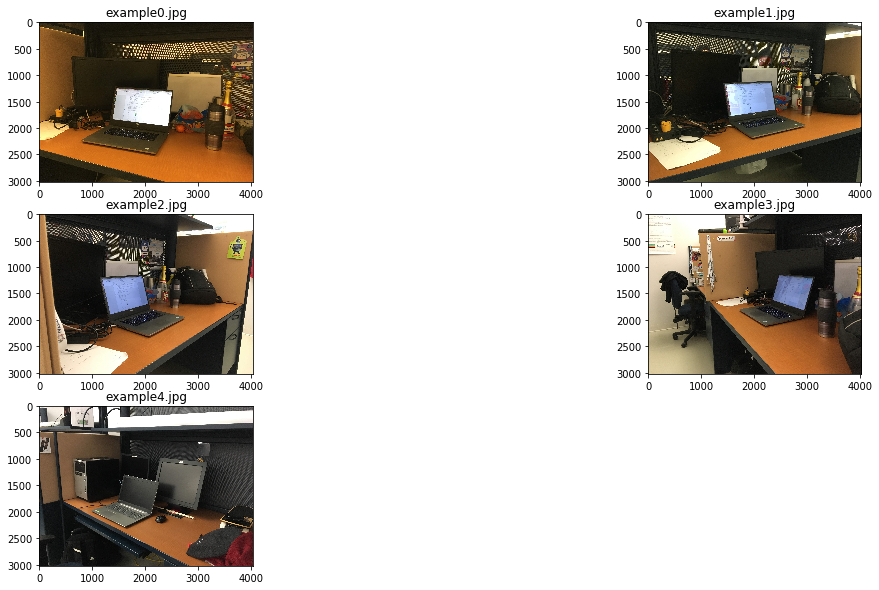

In [21]:
fig = plt.figure(figsize=(20,10))
for i in range(5):
    filename = 'example'+str(i)+'.jpg'
    ax = fig.add_subplot(3,2,1+i)
    img = cv2.imread(filename) #, cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(filename)

In [25]:
imd.sess.close()